In [1]:
from datasets import load_dataset,load_from_disk
from torch.utils.data import Dataset,DataLoader
from torch import nn

In [2]:
dataset = load_dataset('sst')

KeyboardInterrupt: 

In [2]:
dataset2 =load_dataset('multi_nli')

Found cached dataset multi_nli (/home/soumodiptab/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

In [22]:
dataset2.save_to_disk('multi_nli.hf')

Saving the dataset (0/1 shards):   0%|          | 0/392702 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9815 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9832 [00:00<?, ? examples/s]

In [3]:
dataset2 = load_from_disk('multi_nli.hf')

FileNotFoundError: Directory multi_nli.hf not found

In [9]:
dataset = load_from_disk('./data/sst.hf')

In [4]:
dataset2 = load_from_disk('./data/multi_nli.hf')

In [5]:
dataset2 =dataset2['train']

In [7]:
dataset2[0]

{'promptID': 31193,
 'pairID': '31193n',
 'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.',
 'premise_binary_parse': '( ( Conceptually ( cream skimming ) ) ( ( has ( ( ( two ( basic dimensions ) ) - ) ( ( product and ) geography ) ) ) . ) )',
 'premise_parse': '(ROOT (S (NP (JJ Conceptually) (NN cream) (NN skimming)) (VP (VBZ has) (NP (NP (CD two) (JJ basic) (NNS dimensions)) (: -) (NP (NN product) (CC and) (NN geography)))) (. .)))',
 'hypothesis': 'Product and geography are what make cream skimming work. ',
 'hypothesis_binary_parse': '( ( ( Product and ) geography ) ( ( are ( what ( make ( cream ( skimming work ) ) ) ) ) . ) )',
 'hypothesis_parse': '(ROOT (S (NP (NN Product) (CC and) (NN geography)) (VP (VBP are) (SBAR (WHNP (WP what)) (S (VP (VBP make) (NP (NP (NN cream)) (VP (VBG skimming) (NP (NN work)))))))) (. .)))',
 'genre': 'government',
 'label': 1}

In [13]:
dataset_train = dataset['train']
dataset_test = dataset['test']
dataset_val = dataset['validation']

NameError: name 'dataset' is not defined

In [14]:
import torchtext
from torchtext.data.utils import get_tokenizer
import re
from cleantext import clean
import spacy

2023-04-26 21:32:58.265976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:925] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-26 21:32:58.266225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-04-26 21:32:58.266299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2023-04-26 21:32:58.266355: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-04-26 21:32:58.266416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Cou

In [15]:
class DataCleaner:
    def __init__(self):
        self.tokenizer = get_tokenizer('basic_english')
        self.nlp = spacy.load('en_core_web_sm', disable = ['ner', 'tagger', 'parser'])
        self.stopwords = self.nlp.Defaults.stop_words

    def replace_dates(self,text):
        date_format_a = re.sub(r'\d{1,2}/\d{1,2}/\d{2,4}', ' <DATE> ', text)
        date_format_b = re.sub(
            r'[A-Za-z]{2,8}\s\d{1,2},?\s\d {4}', ' <DATE> ', date_format_a)
        date_format_c = re.sub(
            r'\d{2} [A-Z][a-z]{2,8} \d{4}', ' <DATE> ', date_format_b)
        return date_format_c

    def replace_hash_tags(self,text):
        return re.sub(r'(\s|^)#(\w+)', ' <HASHTAG> ', text)

    def remove_special_characters(self,text):
            # remove all special characters 
        return re.sub(r'[^A-Za-z0-9\s]', ' ', text)

    def remove_extra_spaces(self,text):
        return re.sub(r'\s{2,}', ' ', text)

    def replace_hyphenated_words(self,text):
        # replace hyphenated words with words seperated by space
        return re.sub(r'(\w+)-(\w+)', r' \1 \2 ', text)

    def clean_text(self,line):
        line = line.strip()
        line = re.sub(r'<|>', ' ', line)
        line = self.replace_dates(line)
        line = self.replace_hyphenated_words(line)
        line = self.replace_hash_tags(line)
        # remove < and > from the text
        line = clean(line, no_emoji=True,
                    no_urls=True,
                    no_emails=True,
                    no_phone_numbers=True,
                    no_currency_symbols=True,           
                    replace_with_url=" <URL> ",
                    replace_with_email=" <EMAIL> ",
                    replace_with_phone_number=" <PHONE> ",
                    replace_with_currency_symbol=" <CURRENCY> ",
                    lower=True)
        line = self.remove_special_characters(line)
        line = clean(line,no_numbers=True,
                     no_digits=True,
                     no_punct=True,
                     replace_with_number=" <NUMBER> ",
                     replace_with_digit=" ",
                     replace_with_punct="",
                     lower=True)
        line = self.remove_extra_spaces(line)
        tokens=self.tokenizer(line)
        return " ".join(tokens)
    
    def remove_stopwords(self,text):
        tokens = self.tokenizer(text)
        return " ".join([token for token in tokens if token not in self.stopwords])
    
    def lemmatize(self,text):
        doc = self.nlp(text)
        return " ".join([token.lemma_ for token in doc])
    
    def process(self,text):
        text = self.clean_text(text)
        text = self.remove_stopwords(text)
        text = self.lemmatize(text)
        return text

In [16]:
datacleaner = DataCleaner()


In [11]:
size = 0
for text in dataset_train:
    p = text['sentence'].split()
    size=max(len(p),size)
print(size)


52


In [12]:
print(dataset_train[0]["sentence"])
print(datacleaner.process(dataset_train[0]["sentence"]))

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
rock destined st century s new conan s going splash greater arnold schwarzenegger jean claud van damme steven segal


/home/soumodiptab/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [17]:
from  tqdm import tqdm
from collections import Counter
import torch
import numpy as np

In [129]:
class DataPipeline(Dataset):
    def __init__(self, filename,type,max_seq_len=50,min_freq=3,vocab=None):
        self.read_data(filename,type)
        self.max_seq_len = max_seq_len
        if vocab is None:
            self.vocab, self.ind2vocab,self.word_count = self.build_vocab(self.data,min_freq)
        else:
            self.vocab = vocab
            self.ind2vocab = {v: k for k, v in vocab.items()}
            # self.word_count = self.get_word_count(vocab,self.data)
        self.ind2vocab = {ind: word for word, ind in self.vocab.items()}
        

    def get_vocab(self):
        return self.vocab
    def word_to_ind(self,word):
        if word in self.vocab:
            return self.vocab[word]
        else:
            return 1
    def ind_to_word(self,ind):
        return self.ind2vocab[ind]
    
    def read_data(self,filename,type):
        pass
    
    def get_word_count(self,vocab,data):
        word_count = {0: 0}
        for line in data:
            for word in line:
                if word in vocab:
                    word_count[vocab[word]] += 1
                else:
                    word_count[0] += 1
        return word_count
    
    def most_common(self,n):
        counter = Counter(self.word_count)
        common = counter.most_common(n)
        ind_freq = dict(common)
        # convert to word frequency
        word_freq = {}
        for ind in ind_freq:
            word_freq[self.ind2vocab[ind]] = ind_freq[ind]
        return word_freq
    
    @staticmethod
    def build_vocab(data,min_freq):
        word_set = {}
        print('Building vocab:')
        for line in tqdm(data):
            for word in line:
                if word not in word_set:
                    word_set[word]=1
                else:
                    word_set[word]+=1
        # sort the vocab
        word_list = sorted(list(word_set))
        word_count = {0: 0, 1: 0}
        vocab_dict = {"<pad>":0,"<unk>": 1}
        i=2
        for word in tqdm(word_list):
            if word_set[word] >= min_freq:
                vocab_dict[word] = i
                word_count[i] = word_set[word]
                i+=1
            else:
                word_count[0] += word_set[word]
        ind2word = {v: k for k, v in vocab_dict.items()}
        print('Vocab size: {}'.format(len(vocab_dict)))
        return vocab_dict, ind2word, word_count

    def total_count(self):
        return sum(self.word_count.values())

    def __len__(self):
        pass

    def __getitem__(self, idx):
        pass
    
    def get_batches(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=False,drop_last=True)

In [130]:
class SstData(DataPipeline):
    def read_data(self, filename, type):
        datacleaner = DataCleaner()
        data =load_from_disk(filename)
        processed_data = []
        target = []
        for line in tqdm(data[type]):
            processed_data.append(datacleaner.process(line['sentence']).split(" "))
            target.append(line['label'])
        self.data=processed_data
        self.target=target
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sent = self.data[idx]
        label = self.target[idx]
        # paddding the sentences to create sequences of same length
        if len(sent) < self.max_seq_len:
            sent=[self.word_to_ind(token) for token in sent]+[self.word_to_ind("<pad>") for _ in range(self.max_seq_len - len(sent))]
        return torch.LongTensor(sent),torch.Tensor([label])
    

In [168]:
class MultiNliData(DataPipeline):
    def __init__(self, filename,type,max_seq_len=50,min_freq=3,sentence_limit=50000,vocab=None):
        self.sentence_limit = sentence_limit
        super().__init__(filename,type,max_seq_len,min_freq,vocab)
    def read_data(self, filename, type):
        datacleaner = DataCleaner()
        data =load_from_disk(filename)
        processed_data = []
        premise = []
        hypothesis = []
        target = []
        counter = 0
        for line in tqdm(data[type]):
            if counter > self.sentence_limit:
                break
            counter += 1
            p = datacleaner.process(line['premise']).split(" ")
            h = datacleaner.process(line['hypothesis']).split(" ")
            processed_data.append(p)
            processed_data.append(h)
            premise.append(p)
            hypothesis.append(h)
            target.append(line['label'])
        self.data = processed_data
        self.target = target
        self.premise = premise
        self.hypothesis = hypothesis
    def __len__(self):
        return len(self.premise)
    def __getitem__(self, idx):
        premise = self.premise[idx]
        hypothesis = self.hypothesis[idx]
        label = self.target[idx]
        # paddding the sentences to create sequences of same length
        if len(premise) < self.max_seq_len:
            premise=[self.word_to_ind(token) for token in premise]+[self.word_to_ind("<pad>") for _ in range(self.max_seq_len - len(premise))]
        if len(hypothesis) < self.max_seq_len:
            hypothesis=[self.word_to_ind(token) for token in hypothesis]+[self.word_to_ind("<pad>") for _ in range(self.max_seq_len - len(hypothesis))]
        return torch.LongTensor(premise),torch.LongTensor(hypothesis),torch.Tensor([label])

In [187]:
class ElmoDataset(Dataset):
    def __init__(self,dataset :DataPipeline):
        self.data = dataset.data
        self.max_seq_len = dataset.max_seq_len
        self.vocab = dataset.vocab
        self.ind2vocab = dataset.ind2vocab
        self.word_to_ind = dataset.word_to_ind
        self.ind_to_word = dataset.ind_to_word
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sent = self.data[idx]
        # paddding the sentences to create sequences of same length
        if len(sent) < self.max_seq_len:
            sent=[self.word_to_ind(token) for token in sent]+[self.word_to_ind("<pad>") for _ in range(self.max_seq_len - len(sent))]
        forward_data = sent[1:]
        backward_data = sent[:-1]
        return torch.LongTensor(forward_data),torch.LongTensor(backward_data)
    def get_batches(self, batch_size):
        return DataLoader(self, batch_size=batch_size, shuffle=False,drop_last=True)

In [147]:
sst_train = SstData("data/sst.hf","train",80,1)
sst_validation = SstData("data/sst.hf","validation",80,1,sst_train.vocab)
sst_test = SstData("data/sst.hf","test",80,1,sst_train.vocab)

  0%|          | 0/8544 [00:00<?, ?it/s]/home/soumodiptab/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 8544/8544 [00:19<00:00, 437.68it/s]


Building vocab:


100%|██████████| 14886/14886 [00:00<00:00, 1271746.80it/s]


Vocab size: 14888


100%|██████████| 2210/2210 [00:04<00:00, 466.49it/s]


In [156]:
sst_elmo_train = ElmoDataset(sst_train)
sst_elmo_validation = ElmoDataset(sst_validation)
sst_elmo_test = ElmoDataset(sst_test)

In [148]:
sst_train.most_common(10)

{'s': 2612,
 'film': 1166,
 'movie': 1016,
 't': 705,
 'n': 695,
 'like': 516,
 'number': 408,
 '<': 391,
 '>': 391,
 'story': 355}

In [149]:
def load_embeddings(vocab,embeddings_file,dimension):
    # load only the embeddings that are in the vocab
    embeddings = np.zeros((len(vocab), dimension))
    with open(embeddings_file, 'r') as f:
        for line in tqdm(f):
            line = line.split()
            word = line[0]
            if word in vocab:
                embeddings[vocab[word]] = np.array(line[1:], dtype=np.float32)
    return torch.Tensor(embeddings)

In [150]:
embedding_matix=load_embeddings(data_train.get_vocab(),'embeddings/glove/glove.6B.100d.txt',100)

400000it [00:01, 207013.14it/s]


In [139]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [140]:
from matplotlib import pyplot as plt

In [141]:
class ELMo(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, max_len, embedding_matrix):
        super(ELMo, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.max_len = max_len
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix)
        self.embedding.weight = nn.Parameter(self.embedding.weight, requires_grad=True)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim, batch_first=True, bidirectional=True)
        self.linear_out = nn.Linear(hidden_dim*2, vocab_size)
    def forward(self,back_data):
        back_embed = self.embedding(back_data)
        back_lstm1, _ = self.lstm1(back_embed)
        back_lstm2, _ = self.lstm2(back_lstm1)
        linear_out = self.linear_out(back_lstm2)
        return linear_out

In [151]:
elmo = ELMo(len(sst_elmo_train.vocab),100,100,80,embedding_matix)

In [152]:
print(elmo)

ELMo(
  (embedding): Embedding(14888, 100)
  (lstm1): LSTM(100, 100, batch_first=True, bidirectional=True)
  (lstm2): LSTM(200, 100, batch_first=True, bidirectional=True)
  (linear_out): Linear(in_features=200, out_features=14888, bias=True)
)


In [153]:
class ElmoTrainer:
    def __init__(self,epochs=20,lr=0.001,batch_size=50,print_every=1,device='cpu'):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.print_every = print_every
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.lowest_validation_loss = float('inf')
        self.training_loss_history = []
    
    def train(self,model : ELMo,model_save_path,train_data,validation_data):
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.training_loss_history = []
        model.to(self.device)
        for epoch in range(len(range(self.epochs))):
            model.train()
            train_loader = train_data.get_batches(self.batch_size)
            training_loss = 0
            for (forward_data,backward_data) in tqdm(train_loader):
                forward_data = forward_data.to(self.device)
                backward_data = backward_data.to(self.device)
                self.optimizer.zero_grad()
                output = model(backward_data)
                output = output.view(-1, model.vocab_size)
                target = forward_data.view(-1)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                training_loss += loss.item()
            if epoch % self.print_every == 0:
                print('Training Loss : {}'.format(training_loss/len(train_loader)))
            self.__validate(model,model_save_path,validation_data)
            self.training_loss_history.append(training_loss/len(train_loader))

    def __validate(self,model:ELMo,model_save_path,validation_data):
        model.eval()
        model.to(self.device)
        validation_loader = validation_data.get_batches(self.batch_size)
        validation_loss = 0
        for i,(forward_data,backward_data) in tqdm(enumerate(validation_loader)):
            forward_data = forward_data.to(self.device)
            backward_data = backward_data.to(self.device)
            output = model(backward_data)
            output = output.view(-1, model.vocab_size)
            target = forward_data.view(-1)
            loss = self.criterion(output, target)
            validation_loss += loss.item()
        if validation_loss < self.lowest_validation_loss:
            self.lowest_validation_loss = validation_loss
            torch.save(model.state_dict(), model_save_path)
        print('Validation Loss : {}'.format(validation_loss/len(validation_loader)))

    def plot_loss(self):
        plt.plot(self.training_loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.show()

    def get_embeddings(self,model:ELMo):
        elmo_embeddings = list(elmo.parameters())[0].cpu().detach().numpy()
        return torch.FloatTensor(elmo_embeddings)


In [154]:
trainer = ElmoTrainer(epochs=20,lr=0.001,batch_size=50,print_every=1,device='cuda')

In [157]:
trainer.train(elmo,'model/elmo.pt',sst_elmo_train,sst_elmo_validation)

100%|██████████| 170/170 [00:06<00:00, 26.38it/s]


Training Loss : 1.799963189573849


22it [00:00, 78.49it/s]


Validation Loss : 0.9632393690672788


100%|██████████| 170/170 [00:06<00:00, 27.84it/s]


Training Loss : 0.9073111058158033


22it [00:00, 78.22it/s]


Validation Loss : 0.941460595889525


100%|██████████| 170/170 [00:06<00:00, 27.39it/s]


Training Loss : 0.8792830603087649


22it [00:00, 76.45it/s]


Validation Loss : 0.904921371828426


100%|██████████| 170/170 [00:06<00:00, 27.45it/s]


Training Loss : 0.8460151072810678


22it [00:00, 77.26it/s]


Validation Loss : 0.8584469773552634


100%|██████████| 170/170 [00:06<00:00, 27.46it/s]


Training Loss : 0.7948732786757104


22it [00:00, 76.69it/s]


Validation Loss : 0.8283648707649924


100%|██████████| 170/170 [00:06<00:00, 27.21it/s]


Training Loss : 0.7555530845242389


22it [00:00, 76.34it/s]


Validation Loss : 0.808040285652334


100%|██████████| 170/170 [00:06<00:00, 27.53it/s]


Training Loss : 0.7193473008625647


22it [00:00, 77.25it/s]


Validation Loss : 0.7877452373504639


100%|██████████| 170/170 [00:06<00:00, 27.41it/s]


Training Loss : 0.680724718071082


22it [00:00, 77.62it/s]


Validation Loss : 0.760323551568118


100%|██████████| 170/170 [00:06<00:00, 27.18it/s]


Training Loss : 0.6415329377002575


22it [00:00, 74.07it/s]


Validation Loss : 0.7297171516851946


100%|██████████| 170/170 [00:06<00:00, 26.30it/s]


Training Loss : 0.6033848945708836


22it [00:00, 73.29it/s]


Validation Loss : 0.7054075652902777


100%|██████████| 170/170 [00:06<00:00, 26.53it/s]


Training Loss : 0.5679095281397595


22it [00:00, 74.28it/s]


Validation Loss : 0.6851871338757601


100%|██████████| 170/170 [00:06<00:00, 26.72it/s]


Training Loss : 0.5338600684176473


22it [00:00, 75.49it/s]


Validation Loss : 0.6660779660398309


100%|██████████| 170/170 [00:06<00:00, 26.77it/s]


Training Loss : 0.5003323631689829


22it [00:00, 74.98it/s]


Validation Loss : 0.6460265165025537


100%|██████████| 170/170 [00:06<00:00, 26.49it/s]


Training Loss : 0.4668339988326325


22it [00:00, 72.55it/s]


Validation Loss : 0.638757050037384


100%|██████████| 170/170 [00:06<00:00, 25.47it/s]


Training Loss : 0.4334366697598906


22it [00:00, 75.93it/s]


Validation Loss : 0.6054913293231617


100%|██████████| 170/170 [00:06<00:00, 26.65it/s]


Training Loss : 0.3998403398648781


22it [00:00, 75.05it/s]


Validation Loss : 0.5884953466328707


100%|██████████| 170/170 [00:06<00:00, 26.57it/s]


Training Loss : 0.3686848322258276


22it [00:00, 74.94it/s]


Validation Loss : 0.5665621703321283


100%|██████████| 170/170 [00:06<00:00, 25.46it/s]


Training Loss : 0.33924403265118597


22it [00:00, 69.75it/s]


Validation Loss : 0.5560177876190706


100%|██████████| 170/170 [00:06<00:00, 25.32it/s]


Training Loss : 0.31194131148650367


22it [00:00, 73.61it/s]


Validation Loss : 0.5389228652824055


100%|██████████| 170/170 [00:06<00:00, 26.19it/s]


Training Loss : 0.2857701896963751


22it [00:00, 75.59it/s]


Validation Loss : 0.5247802734375


In [158]:
elmo_embeddings =trainer.get_embeddings(elmo)


In [159]:
elmo_embeddings.shape

torch.Size([14888, 100])

In [160]:
elmo_lstm1_param = elmo.lstm1
elmo_lstm2_param = elmo.lstm2

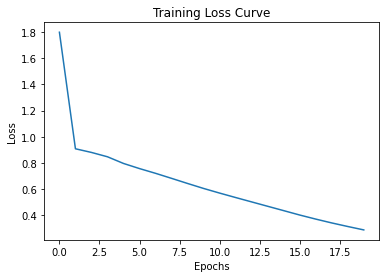

In [161]:
trainer.plot_loss()

In [169]:
multi_nli_train = MultiNliData('data/multi_nli.hf','train',200,3,20000)

  5%|▌         | 20001/392702 [01:19<24:33, 253.02it/s]


Building vocab:


100%|██████████| 27573/27573 [00:00<00:00, 1531396.66it/s]

Vocab size: 12762


In [170]:
multi_nli_validation = MultiNliData('data/multi_nli.hf','validation_matched',200,3,8000,multi_nli_train.get_vocab())

  0%|          | 0/9815 [00:00<?, ?it/s]/home/soumodiptab/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
 82%|████████▏ | 8001/9815 [00:31<00:07, 255.33it/s]


In [188]:
multi_nli_elmo_train = ElmoDataset(multi_nli_train)

In [189]:
multi_nli_elmo_validation = ElmoDataset(multi_nli_validation)

In [233]:
trainer2 = ElmoTrainer(epochs=20,lr=0.001,batch_size=64,print_every=1,device='cuda')

In [208]:
elmo2 = ELMo(len(multi_nli_elmo_train.vocab),100,100,80,embedding_matix)

In [236]:
trainer2.train(elmo2,'model/elmo2.pt',multi_nli_elmo_train,multi_nli_elmo_validation)

100%|██████████| 625/625 [02:05<00:00,  4.99it/s]


Training Loss : 0.22713012924194337


250it [00:24, 10.15it/s]


Validation Loss : 0.1599109906256199


100%|██████████| 625/625 [02:06<00:00,  4.95it/s]


Training Loss : 0.12823632835149765


250it [00:24, 10.23it/s]


Validation Loss : 0.08191098119318485


100%|██████████| 625/625 [02:07<00:00,  4.92it/s]


Training Loss : 0.06852652742862701


250it [00:24, 10.12it/s]


Validation Loss : 0.044936107352375985


100%|██████████| 625/625 [02:07<00:00,  4.89it/s]


Training Loss : 0.03907874436378479


250it [00:24, 10.08it/s]


Validation Loss : 0.02668720070272684


100%|██████████| 625/625 [02:08<00:00,  4.88it/s]


Training Loss : 0.022784243585169315


250it [00:24, 10.08it/s]


Validation Loss : 0.016551169984042644


100%|██████████| 625/625 [02:08<00:00,  4.87it/s]


Training Loss : 0.013045244389027356


250it [00:24, 10.04it/s]


Validation Loss : 0.010600835496559739


100%|██████████| 625/625 [02:08<00:00,  4.88it/s]


Training Loss : 0.007206373928114772


250it [00:24, 10.10it/s]


Validation Loss : 0.007102790081873536


100%|██████████| 625/625 [02:07<00:00,  4.89it/s]


Training Loss : 0.0038897395735606553


250it [00:24, 10.15it/s]


Validation Loss : 0.005025210591964423


100%|██████████| 625/625 [02:08<00:00,  4.88it/s]


Training Loss : 0.00212826248947531


250it [00:24, 10.15it/s]


Validation Loss : 0.003776892692781985


100%|██████████| 625/625 [02:08<00:00,  4.88it/s]


Training Loss : 0.0012039754981175066


250it [00:24, 10.10it/s]


Validation Loss : 0.002969962708186358


100%|██████████| 625/625 [02:09<00:00,  4.83it/s]


Training Loss : 0.0007289943515788764


250it [00:25,  9.98it/s]


Validation Loss : 0.0024107940341345966


100%|██████████| 625/625 [02:08<00:00,  4.85it/s]


Training Loss : 0.00047238183100707827


250it [00:24, 10.00it/s]


Validation Loss : 0.0020372647244948894


 23%|██▎       | 145/625 [00:30<01:39,  4.83it/s]


KeyboardInterrupt: 

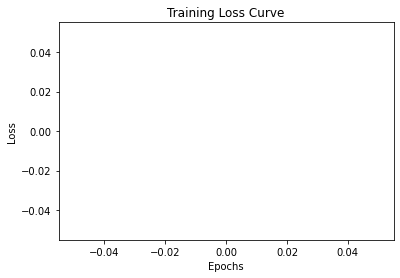

In [237]:
trainer.plot_loss()

In [234]:
import torch

In [235]:
import gc
torch.cuda.empty_cache()
gc.collect()

1652

In [115]:
class SentimentClassifier(nn.Module):
    def __init__(self,embedding_dim,hidden_dim,elmo_embeddings,elmo_l1,elmo_l2,dropout=0.2):
        super(SentimentClassifier, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(elmo_embeddings)
        self.embedding.weight = nn.Parameter(self.embedding.weight, requires_grad=True)
        self.weights = nn.Parameter(torch.tensor([0.33, 0.33, 0.33]), requires_grad=True)
        self.linear1 = nn.Linear(embedding_dim, hidden_dim*2)
        self.lstm1 = elmo_l1
        self.lstm2 = elmo_l2
        self.linear2 = nn.Linear(hidden_dim*2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self,input_data):
        embeds = self.embedding(input_data)
        embeds_change = self.linear1(embeds)
        hidden1, _ = self.lstm1(embeds)
        hidden2, _ = self.lstm2(hidden1)
        elmo_embed = (self.weights[0]*hidden1 + self.weights[1]*hidden2 
                      + self.weights[2]*embeds_change)/(self.weights[0]+self.weights[1]+self.weights[2])
        elmo_embed_max = torch.max(elmo_embed, dim=1)[0]
        elmo_embed_max_drop = self.dropout(elmo_embed_max)
        linear_out = self.linear2(elmo_embed_max_drop)
        return torch.sigmoid(linear_out)

In [116]:
sent_train = DataPipeline('data/sst.hf','train',80,1)
sent_validation = DataPipeline('data/sst.hf','validation',80,1)

  0%|          | 0/8544 [00:00<?, ?it/s]/home/soumodiptab/.local/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 8544/8544 [00:26<00:00, 319.60it/s]


Building vocab:


100%|██████████| 14886/14886 [00:00<00:00, 703675.34it/s]


Vocab size: 14888


100%|██████████| 1101/1101 [00:04<00:00, 275.00it/s]


Building vocab:


100%|██████████| 4657/4657 [00:00<00:00, 703025.98it/s]

Vocab size: 4659


In [104]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score


In [105]:
sent_classifier = SentimentClassifier(100,100,elmo_embeddings,elmo_lstm1_param,elmo_lstm2_param)

In [106]:
class SentTrainer:
    def __init__(self,epochs=20,lr=0.001,batch_size=50,print_every=1,device='cpu'):
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.print_every = print_every
        self.device = device
        self.criterion = nn.MSELoss()
        self.lowest_validation_loss = float('inf')
        self.training_loss_history = []
        self.training_accuracy_history = []
        self.training_f1_score_history = []
        self.validation_loss_history = []
    
    def train(self,model : ELMo,model_save_path,train_data,validation_data):
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.training_loss_history = []
        model.to(self.device)
        for epoch in range(len(range(self.epochs))):
            model.train()
            train_loader = train_data.get_batches(self.batch_size)
            training_loss = 0
            training_acc = 0
            training_f1 = 0
            threshold = 0.5
            for (sent_data,target) in tqdm(train_loader):
                sent_data = sent_data.to(self.device)
                target = target.to(self.device)
                self.optimizer.zero_grad()
                output = model(sent_data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                training_loss += loss.item()
                true_labels = target.cpu().detach().numpy()
                pred_labels = output.cpu().detach().numpy()
                true_labels = (true_labels >= threshold).astype(np.int64)
                pred_labels = (pred_labels >= threshold).astype(np.int64)
                # get accuracy by comparing output with target and detaching from the layer
                training_acc+=accuracy_score(true_labels,pred_labels)
                training_f1+=f1_score(true_labels,pred_labels)
            if epoch % self.print_every == 0:
                print('Training Accuracy : {}'.format(training_acc/len(train_loader)))
            self.__validate(model,model_save_path,validation_data)
            self.training_loss_history.append(training_loss/len(train_loader))
            self.training_accuracy_history.append(training_acc/len(train_loader))
            self.training_f1_score_history.append(training_f1/len(train_loader))

    def __validate(self,model:ELMo,model_save_path,validation_data):
        model.eval()
        model.to(self.device)
        validation_loader = validation_data.get_batches(self.batch_size)
        validation_loss = 0
        validation_acc = 0
        validation_f1 = 0
        threshold = 0.5
        for (sent_data,target) in tqdm(validation_loader):
                sent_data = sent_data.to(self.device)
                target = target.to(self.device)
                output = model(sent_data)
                loss = self.criterion(output, target)
                validation_loss += loss.item()
                true_labels = target.cpu().detach().numpy()
                pred_labels = output.cpu().detach().numpy()
                true_labels = (true_labels >= threshold).astype(np.int64)
                pred_labels = (pred_labels >= threshold).astype(np.int64)
                validation_acc+=accuracy_score(true_labels,pred_labels)
                validation_f1+=f1_score(true_labels,pred_labels)
        if validation_loss < self.lowest_validation_loss:
            self.lowest_validation_loss = validation_loss
            torch.save(model.state_dict(), model_save_path)
        print('Validation Accuracy : {}'.format(validation_acc/len(validation_loader)))

    def plot_loss(self):
        plt.plot(self.training_loss_history)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss Curve')
        plt.show()

    def plot_accuracy(self):
        plt.plot(self.training_accuracy_history)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training Accuracy Curve')
        plt.show()

    def plot_f1_score(self):
        plt.plot(self.training_f1_score_history)
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training F1 Score Curve')
        plt.show()

    

In [107]:
sent_trainer = SentTrainer(epochs=20,lr=0.001,batch_size=50,print_every=1,device='cuda')

In [108]:
sent_trainer.train(sent_classifier,'model/sent_classifier.pt',sent_train,sent_validation)

100%|██████████| 170/170 [00:02<00:00, 57.76it/s]


Training Accuracy : 0.8312941176470584


100%|██████████| 22/22 [00:00<00:00, 115.51it/s]


Validation Accuracy : 0.49000000000000005


100%|██████████| 170/170 [00:02<00:00, 63.96it/s]


Training Accuracy : 0.8399999999999999


100%|██████████| 22/22 [00:00<00:00, 136.53it/s]


Validation Accuracy : 0.48454545454545456


100%|██████████| 170/170 [00:02<00:00, 64.61it/s]


Training Accuracy : 0.8610588235294121


100%|██████████| 22/22 [00:00<00:00, 125.75it/s]


Validation Accuracy : 0.48363636363636364


100%|██████████| 170/170 [00:02<00:00, 62.43it/s]


Training Accuracy : 0.888352941176471


100%|██████████| 22/22 [00:00<00:00, 134.65it/s]


Validation Accuracy : 0.48727272727272725


100%|██████████| 170/170 [00:02<00:00, 64.19it/s]


Training Accuracy : 0.9108235294117644


100%|██████████| 22/22 [00:00<00:00, 136.98it/s]


Validation Accuracy : 0.49272727272727274


100%|██████████| 170/170 [00:02<00:00, 63.65it/s]


Training Accuracy : 0.9277647058823527


100%|██████████| 22/22 [00:00<00:00, 137.59it/s]


Validation Accuracy : 0.4890909090909091


100%|██████████| 170/170 [00:02<00:00, 63.65it/s]


Training Accuracy : 0.9418823529411753


100%|██████████| 22/22 [00:00<00:00, 124.89it/s]


Validation Accuracy : 0.4918181818181818


100%|██████████| 170/170 [00:02<00:00, 61.63it/s]


Training Accuracy : 0.9469411764705876


100%|██████████| 22/22 [00:00<00:00, 138.13it/s]


Validation Accuracy : 0.4872727272727273


100%|██████████| 170/170 [00:02<00:00, 62.91it/s]


Training Accuracy : 0.9536470588235283


100%|██████████| 22/22 [00:00<00:00, 136.02it/s]


Validation Accuracy : 0.4945454545454545


100%|██████████| 170/170 [00:02<00:00, 64.34it/s]


Training Accuracy : 0.9576470588235282


100%|██████████| 22/22 [00:00<00:00, 138.56it/s]


Validation Accuracy : 0.4936363636363637


100%|██████████| 170/170 [00:02<00:00, 62.72it/s]


Training Accuracy : 0.9583529411764696


100%|██████████| 22/22 [00:00<00:00, 126.89it/s]


Validation Accuracy : 0.4936363636363636


100%|██████████| 170/170 [00:02<00:00, 61.16it/s]


Training Accuracy : 0.959764705882352


100%|██████████| 22/22 [00:00<00:00, 136.56it/s]


Validation Accuracy : 0.49090909090909085


100%|██████████| 170/170 [00:02<00:00, 64.32it/s]


Training Accuracy : 0.9610588235294112


100%|██████████| 22/22 [00:00<00:00, 129.76it/s]


Validation Accuracy : 0.4799999999999999


100%|██████████| 170/170 [00:02<00:00, 62.10it/s]


Training Accuracy : 0.9574117647058816


100%|██████████| 22/22 [00:00<00:00, 132.32it/s]


Validation Accuracy : 0.48727272727272725


100%|██████████| 170/170 [00:02<00:00, 60.52it/s]


Training Accuracy : 0.9612941176470576


100%|██████████| 22/22 [00:00<00:00, 126.70it/s]


Validation Accuracy : 0.48727272727272725


100%|██████████| 170/170 [00:02<00:00, 63.48it/s]


Training Accuracy : 0.9612941176470583


100%|██████████| 22/22 [00:00<00:00, 128.62it/s]


Validation Accuracy : 0.4836363636363636


100%|██████████| 170/170 [00:02<00:00, 62.48it/s]


Training Accuracy : 0.9671764705882347


100%|██████████| 22/22 [00:00<00:00, 131.82it/s]


Validation Accuracy : 0.48636363636363633


100%|██████████| 170/170 [00:02<00:00, 61.67it/s]


Training Accuracy : 0.9647058823529405


100%|██████████| 22/22 [00:00<00:00, 104.66it/s]


Validation Accuracy : 0.48545454545454536


100%|██████████| 170/170 [00:03<00:00, 53.44it/s]


Training Accuracy : 0.9598823529411759


100%|██████████| 22/22 [00:00<00:00, 104.83it/s]


Validation Accuracy : 0.4799999999999999


100%|██████████| 170/170 [00:03<00:00, 51.59it/s]


Training Accuracy : 0.9570588235294112


100%|██████████| 22/22 [00:00<00:00, 104.84it/s]

Validation Accuracy : 0.49


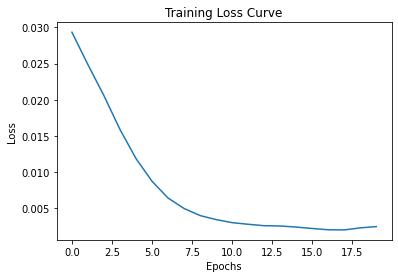

In [111]:
sent_trainer.plot_loss()

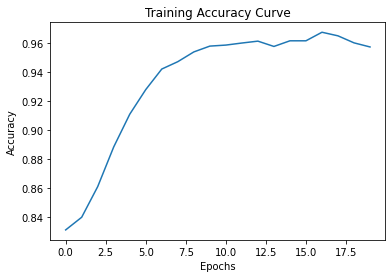

In [112]:
sent_trainer.plot_accuracy()

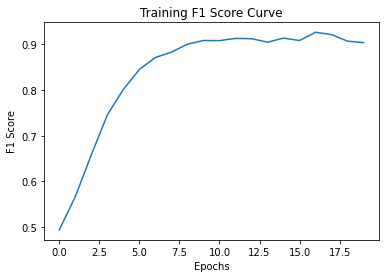

In [113]:
sent_trainer.plot_f1_score()